In [27]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
import tifffile as tiff
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.io import read_image
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import segmentation_models_pytorch as smp
import matplotlib.image as mpimg
from tifffile import imsave
import random
import sys
sys.path.append('../') 
from CagePreprocessing import cages

In [15]:
## 177
# path_img = "/mnt/data1/users/lminaud/path_chips/Chip{chip_id}/{chip_id}_images/20x/FocusMap/Tiles/BF"
# mask_from_roi_path = f"/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/{chip_id}_masks/good_mask_selected"

## 178
# path_img = f'/mnt/data1/users/lminaud/path_chips/Chip{chip_id}/{chip_id}_images/20x/Tiles/BF-T0'
# mask_from_roi_path = f"/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/{chip_id}_masks/kartezio_mask/good_mask_selected"

In [16]:
chip_id = 159

path_img = '/mnt/data1/users/lminaud/path_chips/Chip159/159_images/20x/Tiles/BF_illumination_correction/'

path_mask = '/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks'
roi_zip_path = os.path.join(path_mask, "roi_files")
mask_from_roi_path = os.path.join(path_mask, "mask_from_roi")
predicted_mask_path = os.path.join(path_mask, "predicted_mask_159_roi") # predicted mask from the model 
yes_directory = os.path.join(predicted_mask_path, 'good_mask_selected_roi') # mask selected to train the model on 

path_model = '/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/model_159_roi_after_selection.pth'
# path_model = '/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/model_177_178_180.pth'

os.makedirs(predicted_mask_path, exist_ok = True)
os.makedirs(yes_directory, exist_ok=True)

## Create mask annotation from ROI Fiji

In [17]:
cages.create_combined_mask(path_img, roi_zip_path, mask_from_roi_path)

Mask saved to /mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/mask_from_roi/163032159_Multichannel_20230915_8090_BF.tif 

Mask saved to /mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/mask_from_roi/163218159_Multichannel_20230915_8240_BF.tif 

Mask saved to /mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/mask_from_roi/162940159_Multichannel_20230915_8036_BF.tif 

Mask saved to /mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/mask_from_roi/162920159_Multichannel_20230915_8012_BF.tif 

Mask saved to /mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/mask_from_roi/163146159_Multichannel_20230915_8151_BF.tif 

Mask saved to /mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/mask_from_roi/163102159_Multichannel_20230915_8117_BF.tif 



## Training model

In [18]:
# Get a list of all files in the image folder
mask_files = os.listdir(mask_from_roi_path)

# Create empty lists to store the image and mask paths
list_img = []
list_mask = []

# Iterate through the image files and construct the corresponding mask paths
for img_file in mask_files:

    # Add the image and mask paths to the lists
    list_img.append(os.path.join(path_img, img_file))
    list_mask.append(os.path.join(mask_from_roi_path, img_file))

In [19]:
# Create a list of random indices to shuffle the lists
random_indices = list(range(len(list_img)))
random.shuffle(random_indices)

# Shuffle the lists using the random indices
shuffled_list_img = [list_img[i] for i in random_indices]
shuffled_list_mask = [list_mask[i] for i in random_indices]

# Check that the lengths of both lists match after shuffling
assert len(shuffled_list_img) == len(shuffled_list_mask), "The number of shuffled images and masks does not match!"

# Example of accessing the I-th shuffled mask and its corresponding image
I = 2  # Adjust this to access the desired index
print(f"Shuffled Image {I}: {shuffled_list_img[I]}")
print(f"Shuffled Mask {I}: {shuffled_list_mask[I]}")

list_img = shuffled_list_img 
list_mask = shuffled_list_mask

Shuffled Image 2: /mnt/data1/users/lminaud/path_chips/Chip159/159_images/20x/Tiles/BF_illumination_correction/162920159_Multichannel_20230915_8012_BF.tif
Shuffled Mask 2: /mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/mask_from_roi/162920159_Multichannel_20230915_8012_BF.tif


In [20]:
import tifffile as tiff
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.io import read_image
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, masks_paths, transform=None, target_size=(576, 576)):
        self.image_paths = image_paths
        self.masks_paths = masks_paths
        self.transform = transform
        self.target_size = target_size
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.masks_paths[idx]
        
        image = tiff.imread(image_path)
        image = (image / image.max() * 255).astype(np.uint8)
        image = Image.fromarray(image).convert("L")
        # image = Image.open(image_path).convert("L")
        
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = torch.tensor(np.array(mask)) #, dtype=torch.long) #.squeeze(0)

        return image, mask
    

transform = transforms.Compose([
    transforms.Resize((1152, 1152)),
    transforms.ToTensor(),  # Convert PIL images to tensor
])

# Split into train and test sets (80% train, 20% test)
train_list_img, test_list_img, train_list_mask, test_list_mask = train_test_split(
    list_img, list_mask, test_size=0.2, random_state=42
)

print(f'{len(train_list_img)} images in the training set and {len(test_list_img)} in the test.')

# Create datasets
train_dataset = CustomImageDataset(train_list_img, train_list_mask, transform)
test_dataset = CustomImageDataset(test_list_img, test_list_mask, transform)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True) # the batch size does not matter

4 images in the training set and 2 in the test.


In [21]:
import segmentation_models_pytorch as smp

model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=1, classes=1)
#model = UNet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)


def dice_loss(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    loss = 1 - dice.mean()
    return loss

optimizer = optim.Adam(model.parameters(), lr=1e-3)


def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        
        running_train_loss = 0.0
        total = 0
        total_test = 0
        
        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()

            outputs = model(inputs) #.squeeze(0)
            outputs = torch.sigmoid(outputs)

            masks = masks #.squeeze(0)
            
            train_loss = criterion(outputs, masks)
            train_loss.backward()
            optimizer.step()
            
            running_train_loss += train_loss.item() * inputs.size(0)
            #predicted = (outputs > 0.5).float().squeeze(0) # binarisé
            train_predicted = outputs.detach().cpu().squeeze(0) # continu
            
            total += masks.size(0) 
            
        
        with torch.no_grad(): # phase de test - pas besoin d'updater les poids 
            running_test_loss = 0.0
            for inputs, masks in test_loader:
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs) 
                outputs = torch.sigmoid(outputs)
                test_loss = criterion(outputs, masks)
                running_test_loss += test_loss.item() * inputs.size(0)
                test_predicted = outputs.detach().cpu().squeeze(0) # continu
                
                total_test += masks.size(0) 
                
                
        if epoch % 1 == 0: 
            
            plt.figure(figsize=(10, 5))
            
            plt.subplot(1, 2, 1)
            # plt.imshow(predicted.squeeze(0).cpu(), vmin=0, vmax=1)
            plt.imshow(train_predicted[0,:,:].squeeze(0).cpu(), vmin=0, vmax=1)
            plt.colorbar()
            plt.show()
            
            plt.subplot(1, 2, 2)
            # plt.imshow(predicted.squeeze(0).cpu(), vmin=0, vmax=1)
            plt.imshow(test_predicted[0,:,:].squeeze(0).cpu(), vmin=0, vmax=1)
            plt.colorbar()
            plt.show()
            
        epoch_loss = running_train_loss / total
        epoch_test_loss = running_test_loss / total_test
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')
    
    
    return model


cpu


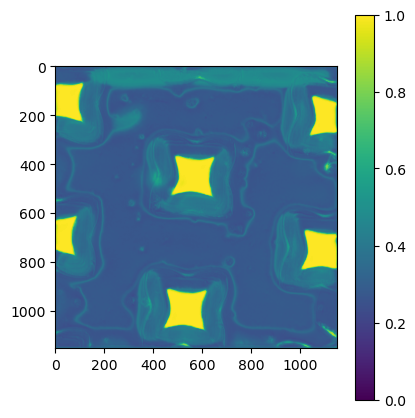

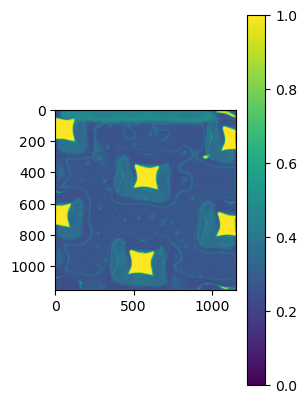

Epoch 1/20, Train Loss: 0.8006, Test Loss: 0.7413


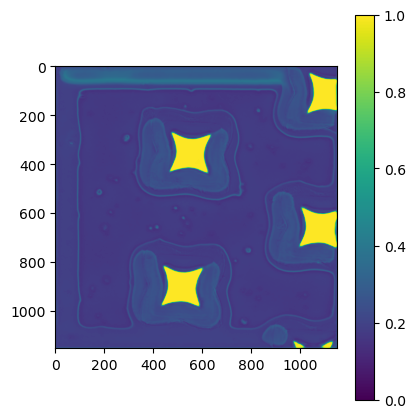

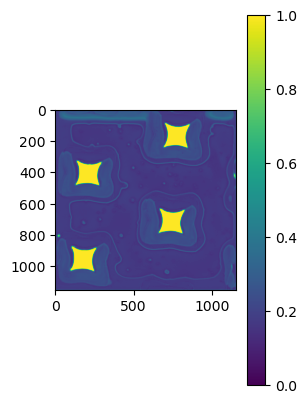

Epoch 2/20, Train Loss: 0.6968, Test Loss: 0.6374


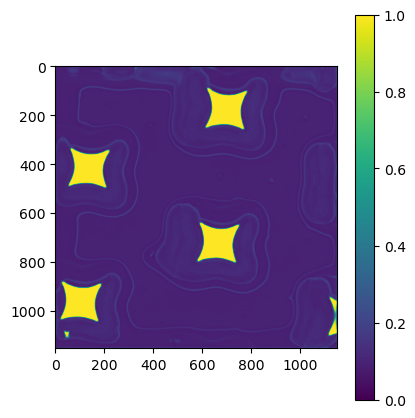

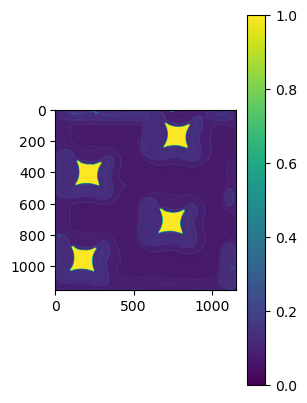

Epoch 3/20, Train Loss: 0.5681, Test Loss: 0.4753


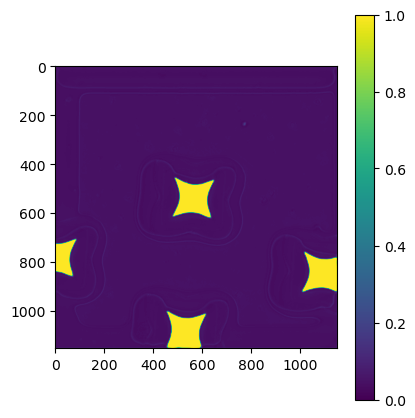

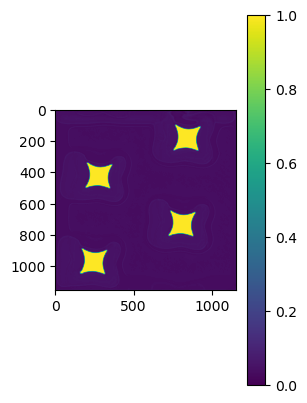

Epoch 4/20, Train Loss: 0.3825, Test Loss: 0.2791


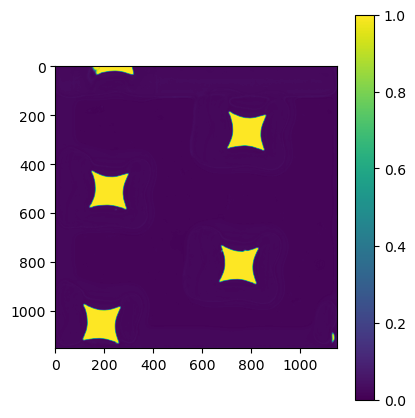

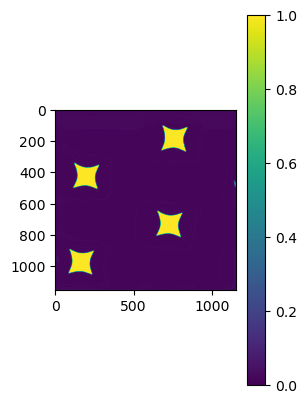

Epoch 5/20, Train Loss: 0.2123, Test Loss: 0.1472


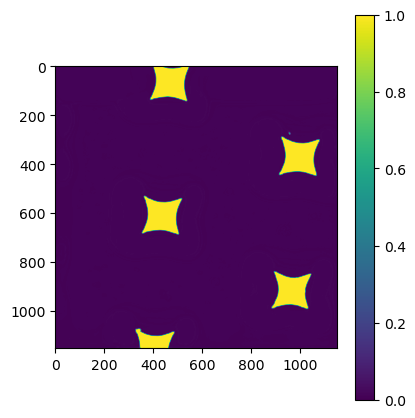

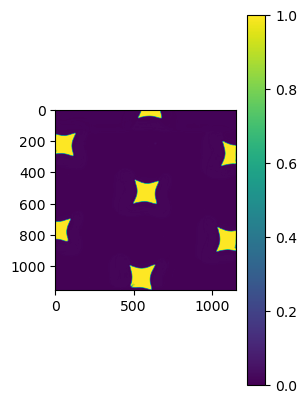

Epoch 6/20, Train Loss: 0.1133, Test Loss: 0.0862


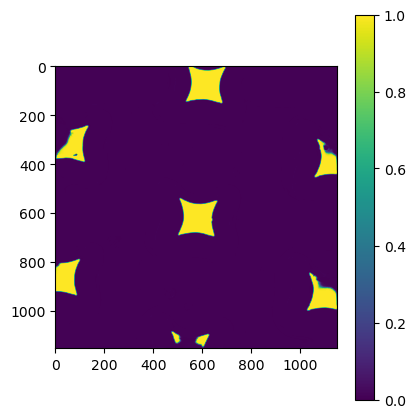

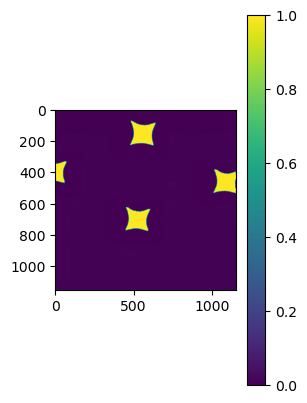

Epoch 7/20, Train Loss: 0.0761, Test Loss: 0.0636


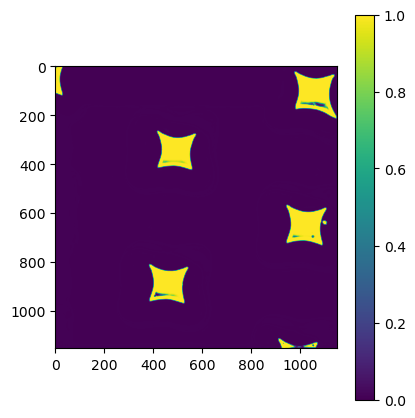

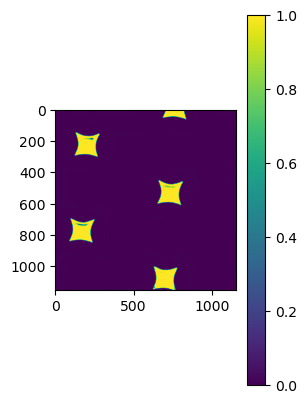

Epoch 8/20, Train Loss: 0.0587, Test Loss: 0.0515


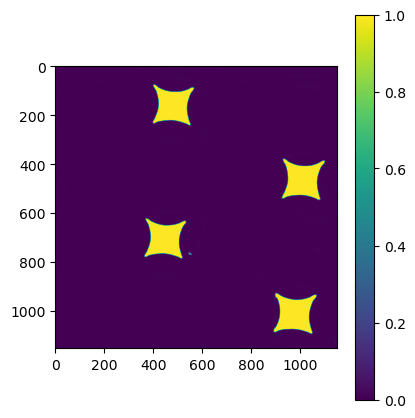

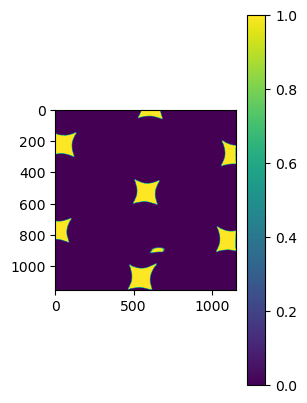

Epoch 9/20, Train Loss: 0.0584, Test Loss: 0.0457


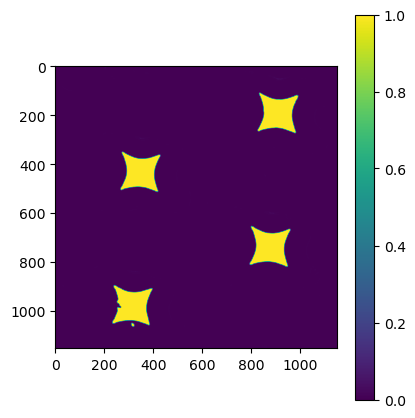

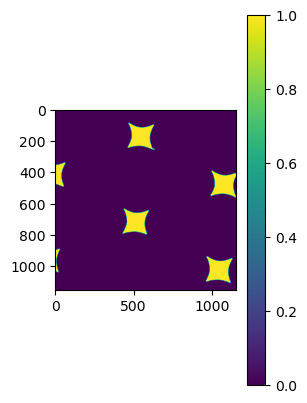

Epoch 10/20, Train Loss: 0.0419, Test Loss: 0.0362


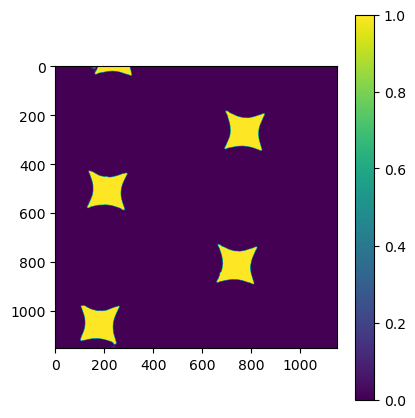

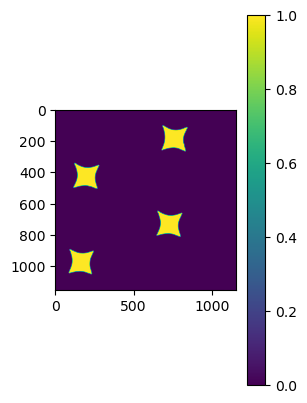

Epoch 11/20, Train Loss: 0.0333, Test Loss: 0.0306


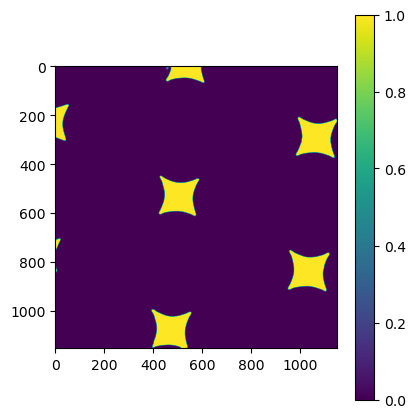

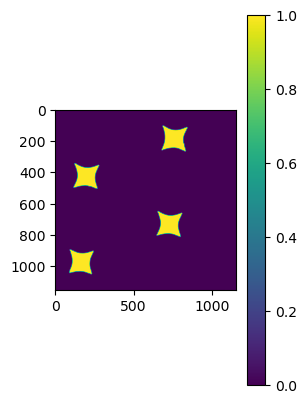

Epoch 12/20, Train Loss: 0.0286, Test Loss: 0.0280


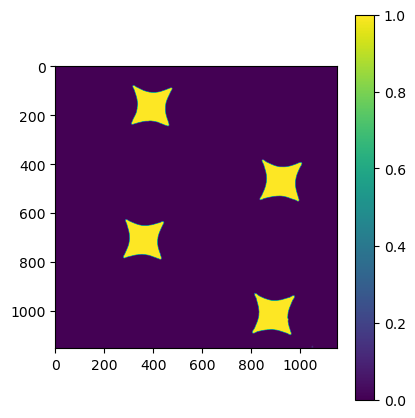

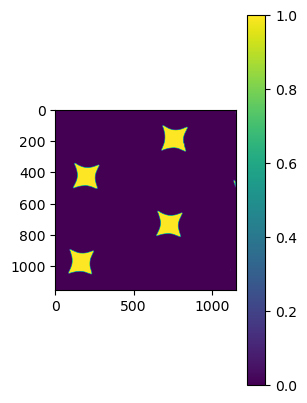

Epoch 13/20, Train Loss: 0.0257, Test Loss: 0.0277


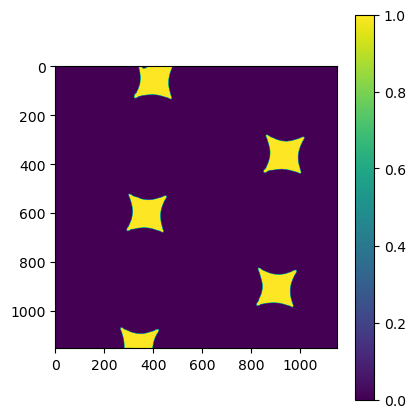

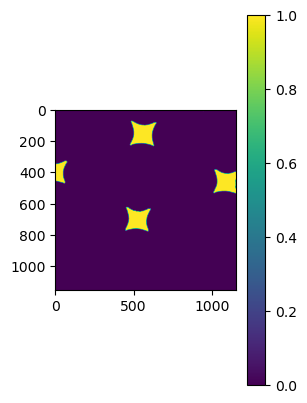

Epoch 14/20, Train Loss: 0.0241, Test Loss: 0.0247


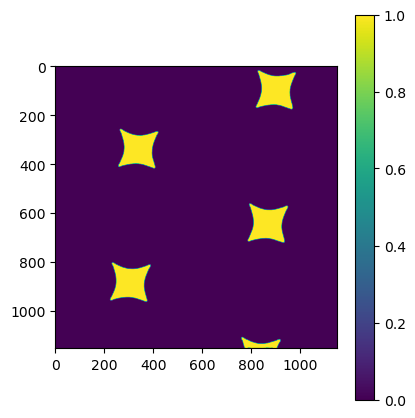

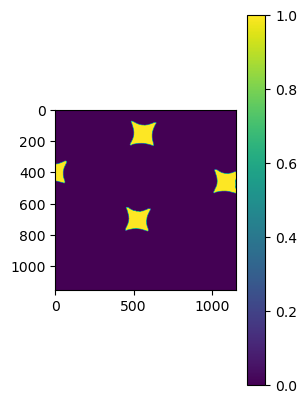

Epoch 15/20, Train Loss: 0.0219, Test Loss: 0.0230


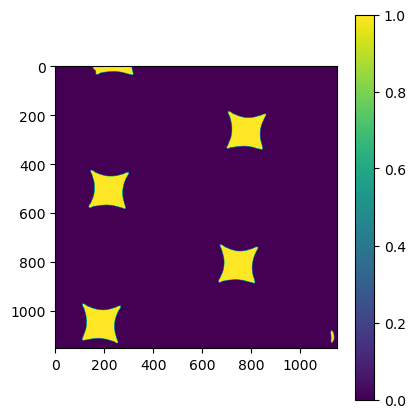

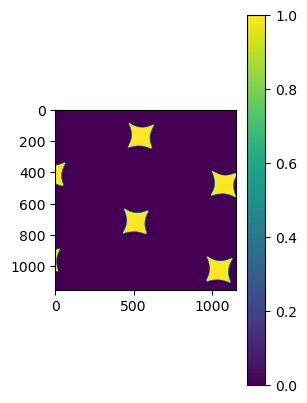

Epoch 16/20, Train Loss: 0.0201, Test Loss: 0.0219


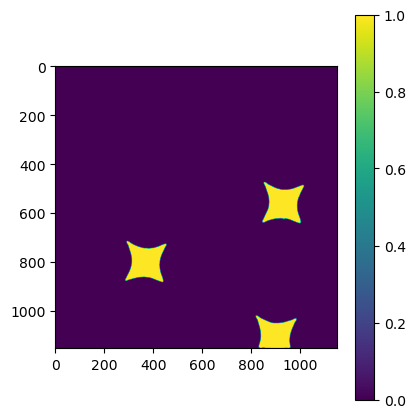

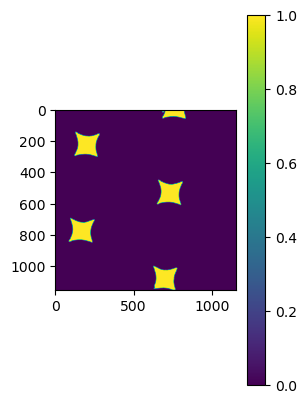

Epoch 17/20, Train Loss: 0.0193, Test Loss: 0.0212


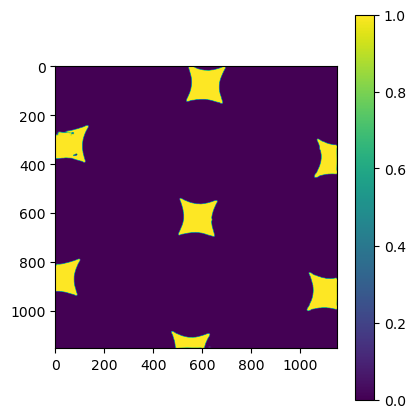

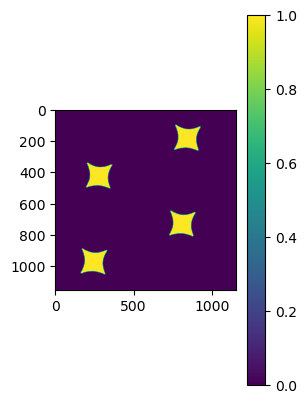

Epoch 18/20, Train Loss: 0.0178, Test Loss: 0.0197


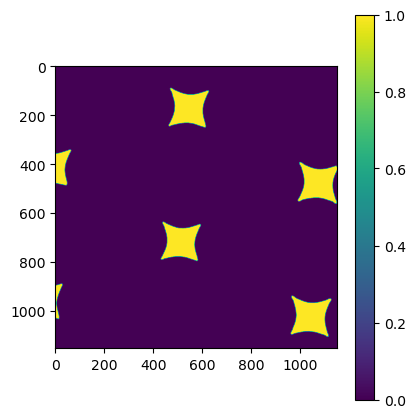

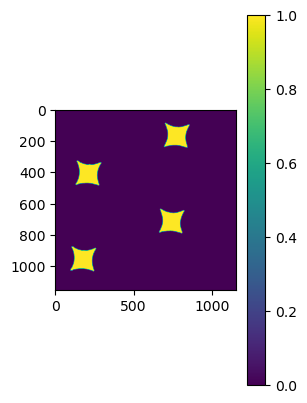

Epoch 19/20, Train Loss: 0.0167, Test Loss: 0.0188


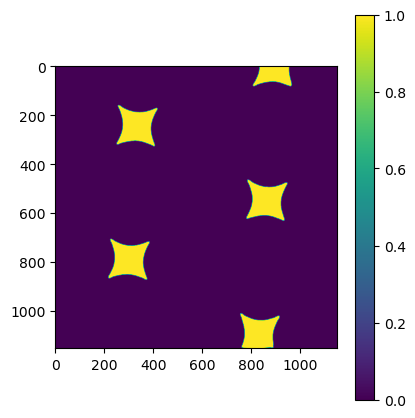

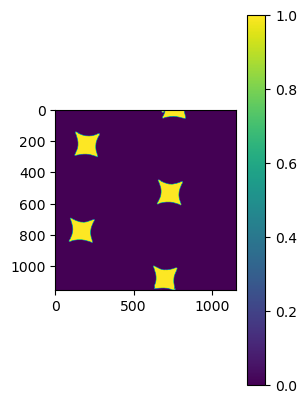

Epoch 20/20, Train Loss: 0.0161, Test Loss: 0.0190


In [57]:
f_model = train_model(model, dice_loss, optimizer, num_epochs=20)

In [58]:
torch.save(f_model.state_dict(), path_model)
print(path_model)

/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/model_159_roi_after_selection.pth


## Apply model on dataset

In [22]:
transform = transforms.Compose([
    transforms.Resize((1152, 1152)),
    transforms.ToTensor(),  # Convert PIL images to tensor
])

In [23]:
# Inference using trained model
def predict_segmentation(model_weights_path, image_path, transform=transform, show=False):
    """
    Predicts segmentation mask for a given image.

    Args:
        model: Trained segmentation model.
        image_path: Path to the input image (TIF file).
        transform: Preprocessing transform (optional).

    Returns:
        Predicted segmentation mask (numpy array).
    """
    
    model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=1, classes=1)
    
    # Load the model weights
    model.load_state_dict(torch.load(model_weights_path, map_location=torch.device('cpu')))

    # Set model to evaluation mode
    model.eval()

    # Move model to device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    with torch.no_grad():
        # Load image and apply preprocessing
        image = tiff.imread(image_path)
        image = (image / image.max() * 255).astype(np.uint8)  # Normalize
        image = transforms.functional.to_pil_image(image).convert("L")  # Convert to PIL
        if transform:
            image = transform(image)

        # Convert to tensor and add batch dimension
        image = image.unsqueeze(0).float()  # Add batch dimension and convert to float

        # Move data to device (CPU or GPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        image = image.to(device)

        # Predict segmentation mask
        output = model(image)
        output = torch.sigmoid(output)  # Apply sigmoid for probability
        predicted_mask = output.squeeze(0).cpu().numpy()  # Remove batch dimension and convert to numpy array
        
        if show:
            # Visualize the original image and predicted mask
            plt.figure(figsize=(12, 6))
            
            tile_id = image_path.split('_')[-2]

            plt.subplot(1, 2, 1)
            image = image.squeeze(1)
            # plt.imshow(image, cmap='gray')
            plt.imshow(image[0, :, :], cmap='gray')  # Access the first channel
            plt.title(f'Original Image - Tile ID {tile_id}')

            plt.subplot(1, 2, 2)
            # predicted_mask = predicted_mask.squeeze(0)
            plt.imshow(predicted_mask.squeeze(0), cmap='viridis', vmin=0, vmax=1)
            plt.colorbar(label='Probability')
            plt.title('Predicted Mask')

            plt.show()

    return predicted_mask

In [24]:
list_files = os.listdir(path_img)
list_files_tif = [f for f in list_files if f.endswith(('.tif', '.png'))]
list_path_files = [os.path.join(path_img, f) for f in list_files_tif]

from random import shuffle
shuffle(list_path_files)
print(len(list_path_files))

480


In [65]:
save_mask = True
show_mask = False
lim = None

for image_path in list_path_files[:lim]:
    predicted_mask = predict_segmentation(model_weights_path = path_model, 
                                          image_path=image_path, show=show_mask)
    
    # Normalize the predicted mask to range [0, 255] if necessary
    # If mask values are between 0 and 1
    if predicted_mask.max() <= 1.0:
        predicted_mask = (predicted_mask * 255).astype('uint8')
        
    # If mask values have a larger range (e.g., 0 to 1000), normalize it:
    elif predicted_mask.max() > 255:
        predicted_mask = ((predicted_mask - predicted_mask.min()) / (predicted_mask.max() - predicted_mask.min()) * 255).astype('uint8')
        
    else:
        # If the range is already 0-255, just convert to uint8 directly
        predicted_mask = predicted_mask.astype('uint8')
    
    output_path = os.path.splitext(os.path.basename(image_path))[0] + '.tif'
    
    binary_mask = np.where(predicted_mask / 255.0 > 0.8, 1, 0).astype('uint8')
    binary_mask = binary_mask[0,:,:]
    # Before saving the binary mask, scale it to 0-255 range
    binary_mask_to_save = (binary_mask * 255).astype('uint8')  # Convert to 0-255 grayscale
    
    # Save the mask
    if save_mask:
        imsave(os.path.join(predicted_mask_path, output_path), binary_mask_to_save)

## Select the best mask for the model training

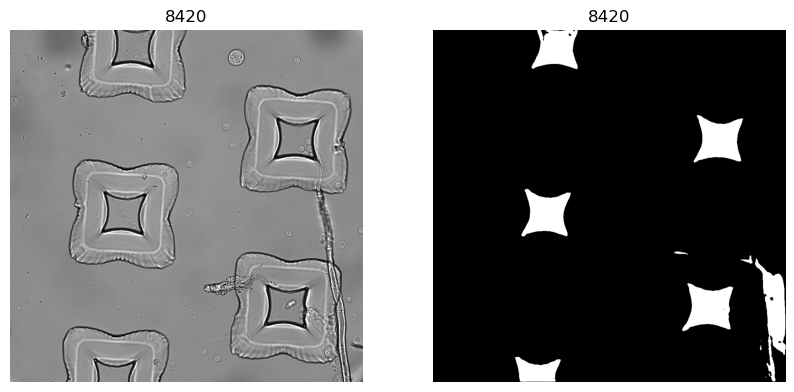

Yes list: 0
No list: 1


In [28]:
lim = 100

# Define the lists to hold the file paths for Yes and No categories
yes_list = []
no_list = []

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(predicted_mask_path) if f.endswith(('png', 'tif'))][:lim]
random.shuffle(image_files)

processed_files = set(os.listdir(yes_directory))

# Loop through each image
for image_file in image_files[:]:
    # Skip the image if it has already been processed
    if image_file in processed_files:
        print(f"Skipping already processed image: {image_file}")
        continue
    
    tile_id = image_file.split('_')[-2]
    # Construct full file path
    image_path = os.path.join(predicted_mask_path, image_file)
    
    bf_image_name = image_file.replace('.png', '')  # Remove the .png extension
    bf_image_file = os.path.join(path_img, bf_image_name)
    
    mask_img = mpimg.imread(image_path)
    bf_img = mpimg.imread(bf_image_file)
    
    # Display the BF and mask images side by side
    plt.figure(figsize=(10, 5))

    # Display the BF image
    plt.subplot(1, 2, 1)
    plt.imshow(bf_img, cmap='gray')
    plt.title(tile_id)
    plt.axis('off')
    
    # Display the mask image
    plt.subplot(1, 2, 2)
    plt.imshow(mask_img, cmap='gray')
    plt.title(tile_id)
    plt.axis('off')
    
    # Show the images
    plt.show()
    
    # Ask the user for input
    decision = input(f"Do you want to add {tile_id} to the Yes list? (Y/N): ").strip().upper()
    
    # Sort the image based on user input
    if decision == 'Y':
        try:
            shutil.copy2(image_path, yes_directory)
            yes_list.append(image_path)
            print(f"Successfully copied {image_path} to yes_directory")
        except Exception as e:
            print(f"Error copying image: {e}")
            
    elif decision == 'N':
        no_list.append(image_path)
    
    # Close the image display
    plt.close('all')
    
    
print(f"Yes list: {len(yes_list)}")
print(f"No list: {len(no_list)}")